This project tries to classify the data from EEG signals as high Valance or low Valance.

In [ ]:
import pandas as pd
import numpy as np
import pickle
import math
import statistics as stat
import scipy.stats as scStat

### The DEAP Dataset

The dataset contains 40 experiments for each of the 32 participants. The labels array contain the valence, arousal, dominance and liking ratings for each participant for each of the 40 experiments. The data array contains 8064 physiological/EEG signal data from 40 different channels for each of the 40 experiments for each of the 32 participants.

### Feature Extraction

We divide the 8064 readings per channel, into 10 batches of approximately 807 readings each. For each batch we extract the mean, median, maximum, minimum, standard deviation, variance, range, skewness and kurtosis values for the 807 readings. Hence for each of the 10 batches of a single channel we extract 9 values mentioned above, we get 90 values as our processed dataset. We further add the net mean, median, maximum, minimum, standard deviation, variance, range, skewness and kurtosis values for the entire 8064 readings along with the experiment and participant number to our dataset, bringing it up to 101 values per channel.

In [ ]:
def extract_features(data, trial, participantNumber):
    extData = []
    for x in np.array_split(data, 10):
        extData.extend(calc_features(x))
    extData.extend(calc_features(data))
    extData.append(trial)
    extData.append(participantNumber)
    return extData

In [ ]:
def calc_features(array):
    return [np.mean(array),
            np.median(array),
            np.var(array),
            np.std(array),
            max(array),
            min(array),
            scStat.mode(array)[0][0],
            scStat.kurtosis(array),
            scStat.skew(array, axis=0, bias=True)]

Features from each channel are extracted and appended to a df so that it can be stored into a csv file and accessed later.

In [ ]:
def process_data_file(fileName, participantNumber):
    with open(fileName, 'rb') as f: content = pickle.load(f, encoding='latin1')
    data = content['data']
    labels = content['labels']
    extracted_features = []
    for index, trialData in enumerate(data):
        for i, channelData in enumerate(trialData):
            extracted_features.append(extract_features(channelData, index, participantNumber))
    df = pd.DataFrame(extracted_features)
    df['Valance Label'] = list(labels[:,0])*int(len(df)/len(labels))
    df['Arousal Label'] = list(labels[:,1])*int(len(df)/len(labels))
    return df

### Reading Data from DEAP Dataset

The data from DEAP Dataset .dat files are read one by one and the extracted features are appended into a csv file.

In [ ]:
files = ['s'+f"{x:02d}"+'.dat' for x in range(1,33)]
participants = [int(x.split('.')[0][-2:]) for x in files]
for f, participantNumber in zip(files, participants):
    process_data_file(f, participantNumber).to_csv('ExtractedFeatures.csv', mode='a', index=False, header=False)
    print("Participant No. : ", participantNumber)

## Learning from extracted features

Lets build deep CNN models to predict Valance and Arousal.

### Valance Model

In [ ]:
columns = [str(i) for i in range(0,99)]
columns.extend(['experiment No', 'participant No', 'Valance Label', 'Arousal Label'])
df = pd.read_csv('ExtractedFeatures.csv', header=None, names=columns)

In [ ]:
df['Valance Label'] = df['Valance Label'].apply(lambda x: 1 if x>5 else 0)
df['Arousal Label'] = df['Arousal Label'].apply(lambda x: 1 if x>5 else 0)

Creating a test set of 2 participants for final testing

In [ ]:
X = df[df.columns.difference(['Valance Label', 'Arousal Label'])].values
X = X.reshape(int(X.shape[0]/40),40,101)
test_set = X[30*40:]
X = X[:30*40]

y_valance = np.array([x for i, x in enumerate(df['Valance Label'].values) if i%1640 < 40])
test_valance = y_valance[30*40:]
y_valance = y_valance[:30*40]

y_arousal = np.array([x for i, x in enumerate(df['Arousal Label'].values) if i%1640 < 40])
test_arousal = y_arousal[30*40:]
y_arousal = y_arousal[:30*40]

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Dropout, Flatten
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

### Building basic CNN Model
This model follows the setup recommended in the paper.

In [ ]:
def build_model():
    model = Sequential()
    
    model.add(Conv2D(100, (3,3), padding="valid", activation='tanh', input_shape = (40, 101, 1)))
    
    model.add(Conv2D(100, (3, 3), activation='tanh' ))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='tanh'))
    model.add(Dropout(0.50))
    
    model.add(Dense(2, activation='softplus'))
    
    sgd = SGD(lr = 0.00001, momentum = 0.9, nesterov = True)
    model.compile(loss ='categorical_crossentropy', optimizer = sgd,metrics=['accuracy'])
    
    return model

###### Building a model for tuning using hyperparameters
The function sets hyperparameters for the following:
- No. of input layers into 1st Conv layer
- No. subsequent conv layers
- No. of units in these layers
- No. of Dense layers
- Learning rate

In [ ]:
def build_hyperparameter_model(hp):
    model = Sequential()
    
    model.add(Conv2D(hp.Int("input_units", min_value=32, max_value=512, step=16),
                     (3,3), padding="valid", activation=hp.Choice('input_activation', values = ['tanh', 'relu']), input_shape = (40, 101, 1)))
    
    for i in range(hp.Int("conv_layers",1, 8)):
        model.add(Conv2D(hp.Int(f"conv_{i}_units", min_value=32, max_value=512, step=32),
                         (3, 3), activation=hp.Choice(f'conv_{i}_activation', values = ['tanh', 'relu']) ))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(hp.Choice('dropout_1', values = [0.25,0.5,0.75])))
    
    model.add(Flatten())
    for i in range(hp.Int("dense_layers",0, 8)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=64, max_value=512, step=32), activation='tanh'))
    
    model.add(Dropout(hp.Choice('dropout_2', values = [0.25,0.5,0.75])))
    
    model.add(Dense(2, activation='softplus'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]) 
    
    sgd = SGD(lr = hp_learning_rate, momentum = 0.9, nesterov = True)
    model.compile(loss ='categorical_crossentropy', optimizer = sgd,metrics=['accuracy'])
    
    return model

### One-Hot encoding labels

In [ ]:
y_valance = to_categorical(y_valance, num_classes=2)
y_arousal = to_categorical(y_arousal, num_classes=2)

### KFold cross validation before hyperparameter tuning

In [ ]:
def kfold_validate(X, y, model):
    kf = KFold(n_splits=int(len(X)/40), shuffle=False)
    losses = []
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        X_train = X_train.reshape(X_train.shape[0], 40, 101, 1)
        X_test = X_test.reshape(X_test.shape[0], 40, 101, 1)
        
        history = model.fit(X_train, y_train, batch_size = 50, 
                            epochs = 10, validation_data = (X_test, y_test))
        score = model.evaluate(X_test, y_test, batch_size = 1)
        losses.append(score[0])
        accuracies.append(score[1])
        
    return (losses, accuracies)

In [ ]:
base_losses, base_accuracies = kfold_validate(X, y_valance, build_model())
print("max loss = ",max(base_losses))
print("max accuracy = ",max(base_accuracies))

Epoch 1/10
24/24 [==============================] - 1s 34ms/step - loss: 0.7923 - accuracy: 0.5259 - val_loss: 0.7820 - val_accuracy: 0.4750
Epoch 2/10
24/24 [==============================] - 1s 21ms/step - loss: 0.7711 - accuracy: 0.4845 - val_loss: 0.7578 - val_accuracy: 0.4750
Epoch 3/10
24/24 [==============================] - 0s 20ms/step - loss: 0.7424 - accuracy: 0.5034 - val_loss: 0.7424 - val_accuracy: 0.4750
Epoch 4/10
24/24 [==============================] - 0s 21ms/step - loss: 0.7377 - accuracy: 0.5026 - val_loss: 0.7448 - val_accuracy: 0.4750
Epoch 5/10
24/24 [==============================] - 0s 21ms/step - loss: 0.7063 - accuracy: 0.5474 - val_loss: 0.7426 - val_accuracy: 0.4750
Epoch 6/10
24/24 [==============================] - 1s 21ms/step - loss: 0.7134 - accuracy: 0.5103 - val_loss: 0.7381 - val_accuracy: 0.4750
Epoch 7/10
24/24 [==============================] - 0s 21ms/step - loss: 0.7048 - accuracy: 0.5328 - val_loss: 0.7343 - val_accuracy: 0.4750
Epoch 8/10
24

## Tuning using Keras-Tuner
- RandomSearch
- Bayesian optimisation
- Hyperband Tuning

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 61kB 2.3MB/s 


In [ ]:
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Hyperband
import time

X_train, X_test, y_train, y_test = train_test_split(X, y_valance)

X_train = X_train.reshape(X_train.shape[0], 40, 101, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 101, 1)

LOG_DIR = f'{int(time.time())}'

### Random Search for valance accuracy

In [ ]:
rand_tuner = RandomSearch(build_hyperparameter_model, 
                    objective='val_accuracy',
                    max_trials=5,
                    executions_per_trial = 1,
                    directory=LOG_DIR)

rand_tuner.search(x=X_train,
            y=y_train,
            epochs=10,
            batch_size=50,
            validation_data=(X_test, y_test))
rand_tuner.get_best_models(1)[0].save('randSearchModel.h5')

Epoch 1/10
20/20 [==============================] - 4s 224ms/step - loss: 0.7334 - accuracy: 0.4896 - val_loss: 0.7044 - val_accuracy: 0.4531
Epoch 2/10
20/20 [==============================] - 4s 176ms/step - loss: 0.7157 - accuracy: 0.5240 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 3/10
20/20 [==============================] - 4s 178ms/step - loss: 0.7284 - accuracy: 0.4875 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 4/10
20/20 [==============================] - 4s 178ms/step - loss: 0.7433 - accuracy: 0.4729 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 5/10
20/20 [==============================] - 4s 178ms/step - loss: 0.7298 - accuracy: 0.4958 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 6/10
20/20 [==============================] - 4s 176ms/step - loss: 0.7272 - accuracy: 0.5094 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 7/10
20/20 [==============================] - 3s 172ms/step - loss: 0.7113 - accuracy: 0.5198 - val_loss: 0.7043 - val_accuracy: 0.4531
Epoch 

Epoch 1/10
20/20 [==============================] - 5s 255ms/step - loss: 0.8036 - accuracy: 0.5021 - val_loss: 0.6850 - val_accuracy: 0.6000
Epoch 2/10
20/20 [==============================] - 4s 201ms/step - loss: 0.7726 - accuracy: 0.5135 - val_loss: 0.6737 - val_accuracy: 0.6313
Epoch 3/10
20/20 [==============================] - 4s 189ms/step - loss: 0.7835 - accuracy: 0.4958 - val_loss: 0.6738 - val_accuracy: 0.6281
Epoch 4/10
20/20 [==============================] - 4s 191ms/step - loss: 0.7537 - accuracy: 0.5302 - val_loss: 0.6787 - val_accuracy: 0.6031
Epoch 5/10
20/20 [==============================] - 4s 192ms/step - loss: 0.7780 - accuracy: 0.4760 - val_loss: 0.6781 - val_accuracy: 0.6094
Epoch 6/10
20/20 [==============================] - 4s 189ms/step - loss: 0.7793 - accuracy: 0.5073 - val_loss: 0.6780 - val_accuracy: 0.6094
Epoch 7/10
20/20 [==============================] - 4s 192ms/step - loss: 0.7523 - accuracy: 0.5042 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 

Epoch 1/10
20/20 [==============================] - 19s 948ms/step - loss: 0.7256 - accuracy: 0.5167 - val_loss: 0.6841 - val_accuracy: 0.5656
Epoch 2/10
20/20 [==============================] - 15s 773ms/step - loss: 0.7000 - accuracy: 0.5260 - val_loss: 0.6805 - val_accuracy: 0.5875
Epoch 3/10
20/20 [==============================] - 15s 747ms/step - loss: 0.6892 - accuracy: 0.5448 - val_loss: 0.6849 - val_accuracy: 0.5719
Epoch 4/10
20/20 [==============================] - 15s 764ms/step - loss: 0.6911 - accuracy: 0.5250 - val_loss: 0.6771 - val_accuracy: 0.6094
Epoch 5/10
20/20 [==============================] - 15s 748ms/step - loss: 0.6939 - accuracy: 0.5240 - val_loss: 0.6726 - val_accuracy: 0.6062
Epoch 6/10
20/20 [==============================] - 15s 750ms/step - loss: 0.6839 - accuracy: 0.5677 - val_loss: 0.6721 - val_accuracy: 0.6031
Epoch 7/10
20/20 [==============================] - 15s 750ms/step - loss: 0.6876 - accuracy: 0.5458 - val_loss: 0.6731 - val_accuracy: 0.6062

Epoch 1/10
20/20 [==============================] - 6s 310ms/step - loss: 0.8204 - accuracy: 0.5063 - val_loss: 0.6762 - val_accuracy: 0.6125
Epoch 2/10
20/20 [==============================] - 5s 241ms/step - loss: 0.7656 - accuracy: 0.5094 - val_loss: 0.6847 - val_accuracy: 0.5531
Epoch 3/10
20/20 [==============================] - 5s 242ms/step - loss: 0.7460 - accuracy: 0.5177 - val_loss: 0.6816 - val_accuracy: 0.5781
Epoch 4/10
20/20 [==============================] - 5s 242ms/step - loss: 0.7436 - accuracy: 0.4990 - val_loss: 0.6807 - val_accuracy: 0.5938
Epoch 5/10
20/20 [==============================] - 5s 241ms/step - loss: 0.7243 - accuracy: 0.5167 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 6/10
20/20 [==============================] - 5s 242ms/step - loss: 0.7279 - accuracy: 0.5198 - val_loss: 0.6811 - val_accuracy: 0.6000
Epoch 7/10
20/20 [==============================] - 5s 241ms/step - loss: 0.7366 - accuracy: 0.4833 - val_loss: 0.6827 - val_accuracy: 0.5875
Epoch 

Epoch 1/10
20/20 [==============================] - 12s 586ms/step - loss: 0.7156 - accuracy: 0.4938 - val_loss: 0.6815 - val_accuracy: 0.5906
Epoch 2/10
20/20 [==============================] - 10s 492ms/step - loss: 0.7105 - accuracy: 0.5146 - val_loss: 0.6807 - val_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 7s 365ms/step - loss: 0.7131 - accuracy: 0.5198 - val_loss: 0.6793 - val_accuracy: 0.5844
Epoch 4/10
20/20 [==============================] - 7s 367ms/step - loss: 0.7180 - accuracy: 0.5156 - val_loss: 0.6783 - val_accuracy: 0.5906
Epoch 5/10
20/20 [==============================] - 7s 368ms/step - loss: 0.6949 - accuracy: 0.5375 - val_loss: 0.6786 - val_accuracy: 0.5875
Epoch 6/10
20/20 [==============================] - 7s 370ms/step - loss: 0.7201 - accuracy: 0.4844 - val_loss: 0.6783 - val_accuracy: 0.5906
Epoch 7/10
20/20 [==============================] - 7s 369ms/step - loss: 0.6982 - accuracy: 0.5354 - val_loss: 0.6775 - val_accuracy: 0.5875
Epoc

INFO:tensorflow:Oracle triggered exit
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: randSearchModel/assets


###  Bayesian optimisation tuner for valance accuracy

In [ ]:
bayesian_tuner = kt.BayesianOptimization(build_hyperparameter_model,
                                         objective='val_accuracy', 
                                         max_trials=5,
                                         executions_per_trial = 1,
                                         directory=LOG_DIR)

bayesian_tuner.search(x=X_train,
                      y=y_train,
                      epochs=10,
                      batch_size=50,
                      validation_data=(X_test, y_test))
bayesian_tuner.get_best_models(1)[0].save('bayesianModel.h5')

Epoch 1/10
20/20 [==============================] - 4s 190ms/step - loss: 0.8153 - accuracy: 0.4792 - val_loss: 0.7884 - val_accuracy: 0.3969
Epoch 2/10
20/20 [==============================] - 3s 148ms/step - loss: 0.7932 - accuracy: 0.4854 - val_loss: 0.7747 - val_accuracy: 0.4000
Epoch 3/10
20/20 [==============================] - 3s 147ms/step - loss: 0.8020 - accuracy: 0.4781 - val_loss: 0.7616 - val_accuracy: 0.4000
Epoch 4/10
20/20 [==============================] - 3s 151ms/step - loss: 0.7816 - accuracy: 0.4708 - val_loss: 0.7499 - val_accuracy: 0.4031
Epoch 5/10
20/20 [==============================] - 3s 151ms/step - loss: 0.7673 - accuracy: 0.4708 - val_loss: 0.7406 - val_accuracy: 0.4062
Epoch 6/10
20/20 [==============================] - 3s 150ms/step - loss: 0.7593 - accuracy: 0.4917 - val_loss: 0.7326 - val_accuracy: 0.4062
Epoch 7/10
20/20 [==============================] - 3s 153ms/step - loss: 0.7708 - accuracy: 0.4823 - val_loss: 0.7255 - val_accuracy: 0.4125
Epoch 

Epoch 1/10
20/20 [==============================] - 16s 788ms/step - loss: 0.7089 - accuracy: 0.5177 - val_loss: 0.6825 - val_accuracy: 0.6031
Epoch 2/10
20/20 [==============================] - 12s 591ms/step - loss: 0.7016 - accuracy: 0.5115 - val_loss: 0.6939 - val_accuracy: 0.4531
Epoch 3/10
20/20 [==============================] - 12s 594ms/step - loss: 0.6922 - accuracy: 0.5260 - val_loss: 0.6784 - val_accuracy: 0.6031
Epoch 4/10
20/20 [==============================] - 12s 599ms/step - loss: 0.6908 - accuracy: 0.5219 - val_loss: 0.6866 - val_accuracy: 0.6031
Epoch 5/10
20/20 [==============================] - 12s 603ms/step - loss: 0.6996 - accuracy: 0.5115 - val_loss: 0.6955 - val_accuracy: 0.4031
Epoch 6/10
20/20 [==============================] - 12s 605ms/step - loss: 0.6903 - accuracy: 0.5292 - val_loss: 0.6716 - val_accuracy: 0.6031
Epoch 7/10
20/20 [==============================] - 12s 602ms/step - loss: 0.6968 - accuracy: 0.5333 - val_loss: 0.6918 - val_accuracy: 0.5875

Epoch 1/10
20/20 [==============================] - 7s 369ms/step - loss: 1.0669 - accuracy: 0.4896 - val_loss: 0.7461 - val_accuracy: 0.4250
Epoch 2/10
20/20 [==============================] - 6s 305ms/step - loss: 1.0609 - accuracy: 0.4802 - val_loss: 0.7430 - val_accuracy: 0.4437
Epoch 3/10
20/20 [==============================] - 6s 307ms/step - loss: 0.9558 - accuracy: 0.5375 - val_loss: 0.7395 - val_accuracy: 0.4437
Epoch 4/10
20/20 [==============================] - 6s 307ms/step - loss: 1.0066 - accuracy: 0.4958 - val_loss: 0.7363 - val_accuracy: 0.4375
Epoch 5/10
20/20 [==============================] - 6s 307ms/step - loss: 1.0479 - accuracy: 0.4833 - val_loss: 0.7326 - val_accuracy: 0.4594
Epoch 6/10
20/20 [==============================] - 6s 302ms/step - loss: 1.0829 - accuracy: 0.4833 - val_loss: 0.7295 - val_accuracy: 0.4594
Epoch 7/10
20/20 [==============================] - 6s 303ms/step - loss: 1.0195 - accuracy: 0.5010 - val_loss: 0.7277 - val_accuracy: 0.4625
Epoch 

Epoch 1/10
20/20 [==============================] - 1s 36ms/step - loss: 0.7044 - accuracy: 0.5031 - val_loss: 0.6803 - val_accuracy: 0.5938
Epoch 2/10
20/20 [==============================] - 1s 29ms/step - loss: 0.6984 - accuracy: 0.5104 - val_loss: 0.6734 - val_accuracy: 0.6031
Epoch 3/10
20/20 [==============================] - 0s 16ms/step - loss: 0.6980 - accuracy: 0.5094 - val_loss: 0.6761 - val_accuracy: 0.6031
Epoch 4/10
20/20 [==============================] - 0s 15ms/step - loss: 0.6814 - accuracy: 0.5656 - val_loss: 0.7062 - val_accuracy: 0.4062
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.6820 - accuracy: 0.5583 - val_loss: 0.6627 - val_accuracy: 0.6031
Epoch 6/10
20/20 [==============================] - 1s 26ms/step - loss: 0.6825 - accuracy: 0.5688 - val_loss: 0.6757 - val_accuracy: 0.6313
Epoch 7/10
20/20 [==============================] - 0s 16ms/step - loss: 0.6747 - accuracy: 0.5792 - val_loss: 0.7249 - val_accuracy: 0.4313
Epoch 8/10
20

Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.7047 - accuracy: 0.4906 - val_loss: 0.6875 - val_accuracy: 0.5469
Epoch 2/10
20/20 [==============================] - 0s 16ms/step - loss: 0.6960 - accuracy: 0.5094 - val_loss: 0.6827 - val_accuracy: 0.5844
Epoch 3/10
20/20 [==============================] - 0s 12ms/step - loss: 0.6958 - accuracy: 0.5073 - val_loss: 0.6929 - val_accuracy: 0.4969
Epoch 4/10
20/20 [==============================] - 0s 17ms/step - loss: 0.7004 - accuracy: 0.4938 - val_loss: 0.6805 - val_accuracy: 0.5875
Epoch 5/10
20/20 [==============================] - 1s 28ms/step - loss: 0.6926 - accuracy: 0.5188 - val_loss: 0.6839 - val_accuracy: 0.6094
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.6943 - accuracy: 0.5177 - val_loss: 0.6776 - val_accuracy: 0.6000
Epoch 7/10
20/20 [==============================] - 0s 12ms/step - loss: 0.6942 - accuracy: 0.5229 - val_loss: 0.6856 - val_accuracy: 0.5969
Epoch 8/10
20

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: bayesianModel/assets


### Hyperband tuner for valance accuracy

In [ ]:
hyperband_tuner = kt.Hyperband(build_hyperparameter_model,
                               objective='val_accuracy', 
                               max_epochs=5, 
                               directory=LOG_DIR)

hyperband_tuner.search(x=X_train,
                      y=y_train,
                      epochs=10,
                      batch_size=50,
                      validation_data=(X_test, y_test))
hyperband_tuner.get_best_models(1)[0].save('hyperbandModel.h5')

Epoch 1/2
20/20 [==============================] - 4s 198ms/step - loss: 0.7096 - accuracy: 0.5271 - val_loss: 0.6722 - val_accuracy: 0.6031
Epoch 2/2
20/20 [==============================] - 3s 158ms/step - loss: 0.7181 - accuracy: 0.5167 - val_loss: 0.6722 - val_accuracy: 0.6031


Epoch 1/2
20/20 [==============================] - 17s 842ms/step - loss: 0.7123 - accuracy: 0.5448 - val_loss: 0.6872 - val_accuracy: 0.5281
Epoch 2/2
20/20 [==============================] - 13s 665ms/step - loss: 0.7217 - accuracy: 0.5115 - val_loss: 0.6834 - val_accuracy: 0.5406


Epoch 1/2
20/20 [==============================] - 10s 504ms/step - loss: 0.7038 - accuracy: 0.5031 - val_loss: 0.6913 - val_accuracy: 0.5188
Epoch 2/2
20/20 [==============================] - 8s 410ms/step - loss: 0.6991 - accuracy: 0.5229 - val_loss: 0.6875 - val_accuracy: 0.5719


Epoch 1/2
20/20 [==============================] - 25s 1s/step - loss: 0.7181 - accuracy: 0.4948 - val_loss: 0.7103 - val_accuracy: 0.3969
Epoch 2/2
20/20 [==============================] - 20s 984ms/step - loss: 0.7084 - accuracy: 0.5208 - val_loss: 0.7099 - val_accuracy: 0.3969


Epoch 1/2
20/20 [==============================] - 18s 891ms/step - loss: 0.7937 - accuracy: 0.5021 - val_loss: 0.7403 - val_accuracy: 0.4094
Epoch 2/2
20/20 [==============================] - 15s 745ms/step - loss: 0.8181 - accuracy: 0.4833 - val_loss: 0.7371 - val_accuracy: 0.4187


Epoch 3/5
20/20 [==============================] - 3s 163ms/step - loss: 0.7165 - accuracy: 0.4948 - val_loss: 0.7030 - val_accuracy: 0.4844
Epoch 4/5
20/20 [==============================] - 3s 151ms/step - loss: 0.7137 - accuracy: 0.4812 - val_loss: 0.7029 - val_accuracy: 0.4844
Epoch 5/5
20/20 [==============================] - 3s 153ms/step - loss: 0.7150 - accuracy: 0.5000 - val_loss: 0.7027 - val_accuracy: 0.4812


Epoch 3/5
20/20 [==============================] - 8s 422ms/step - loss: 0.7109 - accuracy: 0.4760 - val_loss: 0.7182 - val_accuracy: 0.3969
Epoch 4/5
20/20 [==============================] - 8s 418ms/step - loss: 0.7069 - accuracy: 0.4760 - val_loss: 0.7079 - val_accuracy: 0.4062
Epoch 5/5
20/20 [==============================] - 8s 415ms/step - loss: 0.7045 - accuracy: 0.4698 - val_loss: 0.6994 - val_accuracy: 0.4469


Epoch 1/5
20/20 [==============================] - 13s 669ms/step - loss: 0.7416 - accuracy: 0.5135 - val_loss: 0.6846 - val_accuracy: 0.5906
Epoch 2/5
20/20 [==============================] - 11s 545ms/step - loss: 0.7109 - accuracy: 0.5365 - val_loss: 0.7089 - val_accuracy: 0.4000
Epoch 3/5
20/20 [==============================] - 12s 575ms/step - loss: 0.7187 - accuracy: 0.5260 - val_loss: 0.6722 - val_accuracy: 0.6031
Epoch 4/5
20/20 [==============================] - 11s 543ms/step - loss: 0.7080 - accuracy: 0.5125 - val_loss: 0.6733 - val_accuracy: 0.6031
Epoch 5/5
20/20 [==============================] - 11s 542ms/step - loss: 0.7140 - accuracy: 0.5188 - val_loss: 0.6887 - val_accuracy: 0.5625


Epoch 1/5
20/20 [==============================] - 17s 840ms/step - loss: 0.7421 - accuracy: 0.5125 - val_loss: 0.6880 - val_accuracy: 0.6031
Epoch 2/5
20/20 [==============================] - 11s 542ms/step - loss: 0.7093 - accuracy: 0.5198 - val_loss: 0.6827 - val_accuracy: 0.6031
Epoch 3/5
20/20 [==============================] - 11s 544ms/step - loss: 0.7119 - accuracy: 0.5094 - val_loss: 0.6859 - val_accuracy: 0.6031
Epoch 4/5
20/20 [==============================] - 11s 546ms/step - loss: 0.7055 - accuracy: 0.5135 - val_loss: 0.6735 - val_accuracy: 0.6031
Epoch 5/5
20/20 [==============================] - 11s 547ms/step - loss: 0.6998 - accuracy: 0.5156 - val_loss: 0.6794 - val_accuracy: 0.6031


Epoch 1/5
20/20 [==============================] - 12s 585ms/step - loss: 0.7369 - accuracy: 0.4812 - val_loss: 0.7039 - val_accuracy: 0.4844
Epoch 2/5
20/20 [==============================] - 18s 911ms/step - loss: 0.7267 - accuracy: 0.5146 - val_loss: 0.7026 - val_accuracy: 0.5000
Epoch 3/5
20/20 [==============================] - 29s 1s/step - loss: 0.7423 - accuracy: 0.4990 - val_loss: 0.7011 - val_accuracy: 0.5063
Epoch 4/5
20/20 [==============================] - 6s 309ms/step - loss: 0.7446 - accuracy: 0.4938 - val_loss: 0.6999 - val_accuracy: 0.5063
Epoch 5/5
20/20 [==============================] - 18s 903ms/step - loss: 0.7424 - accuracy: 0.4896 - val_loss: 0.6989 - val_accuracy: 0.5094


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: hyperbandModel/assets


### Kfold cross validate across 30 samples to get accuracies and losses


In [ ]:
best_model_randSearch = load_model('randSearchModel.h5')
rand_losses, rand_accuracies = kfold_validate(X, y_valance, best_model_randSearch)

Epoch 1/10
24/24 [==============================] - 3s 134ms/step - loss: 0.7382 - accuracy: 0.5293 - val_loss: 0.7180 - val_accuracy: 0.4750
Epoch 2/10
24/24 [==============================] - 2s 98ms/step - loss: 0.7509 - accuracy: 0.5250 - val_loss: 0.7201 - val_accuracy: 0.4750
Epoch 3/10
24/24 [==============================] - 2s 96ms/step - loss: 0.7340 - accuracy: 0.5336 - val_loss: 0.7138 - val_accuracy: 0.4750
Epoch 4/10
24/24 [==============================] - 2s 97ms/step - loss: 0.7639 - accuracy: 0.5164 - val_loss: 0.7156 - val_accuracy: 0.4750
Epoch 5/10
24/24 [==============================] - 2s 99ms/step - loss: 0.7420 - accuracy: 0.5112 - val_loss: 0.7147 - val_accuracy: 0.4750
Epoch 6/10
24/24 [==============================] - 2s 96ms/step - loss: 0.7242 - accuracy: 0.5259 - val_loss: 0.7155 - val_accuracy: 0.4750
Epoch 7/10
24/24 [==============================] - 2s 97ms/step - loss: 0.7479 - accuracy: 0.5216 - val_loss: 0.7171 - val_accuracy: 0.4750
Epoch 8/10
2

In [ ]:
best_model_bayesian = load_model('bayesianModel.h5')
bayesian_losses, bayesian_accuracies = kfold_validate(X, y_valance, best_model_bayesian)

Epoch 1/10
24/24 [==============================] - 1s 22ms/step - loss: 0.6764 - accuracy: 0.5879 - val_loss: 0.6613 - val_accuracy: 0.5000
Epoch 2/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6703 - accuracy: 0.5819 - val_loss: 0.6408 - val_accuracy: 0.7000
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6614 - accuracy: 0.6121 - val_loss: 0.6265 - val_accuracy: 0.7500
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6530 - accuracy: 0.6276 - val_loss: 0.6225 - val_accuracy: 0.7500
Epoch 5/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6582 - accuracy: 0.6121 - val_loss: 0.6425 - val_accuracy: 0.6250
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6509 - accuracy: 0.6336 - val_loss: 0.7552 - val_accuracy: 0.4750
Epoch 7/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6464 - accuracy: 0.6224 - val_loss: 0.6227 - val_accuracy: 0.6250
Epoch 8/10
24

In [ ]:
best_model_hyperband = load_model('hyperbandModel.h5')
hyperband_losses, hyperband_accuracies = kfold_validate(X, y_valance, best_model_hyperband)

Epoch 1/10
24/24 [==============================] - 0s 20ms/step - loss: 0.6771 - accuracy: 0.5759 - val_loss: 0.7162 - val_accuracy: 0.4750
Epoch 2/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6708 - accuracy: 0.5845 - val_loss: 0.6640 - val_accuracy: 0.5250
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6663 - accuracy: 0.5871 - val_loss: 0.6279 - val_accuracy: 0.7000
Epoch 4/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6552 - accuracy: 0.6129 - val_loss: 0.6564 - val_accuracy: 0.5500
Epoch 5/10
24/24 [==============================] - 0s 12ms/step - loss: 0.6523 - accuracy: 0.6086 - val_loss: 0.6116 - val_accuracy: 0.7000
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6465 - accuracy: 0.6233 - val_loss: 0.7386 - val_accuracy: 0.4750
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 0.6486 - accuracy: 0.6284 - val_loss: 0.7040 - val_accuracy: 0.4750
Epoch 8/10
24

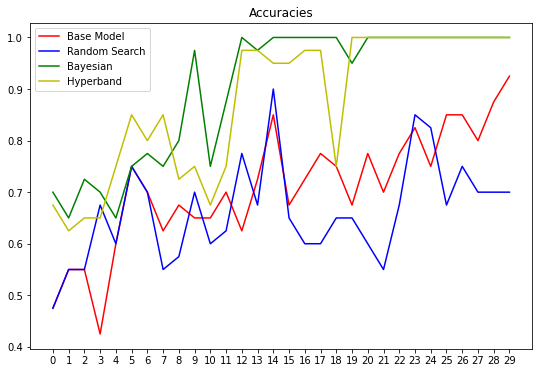

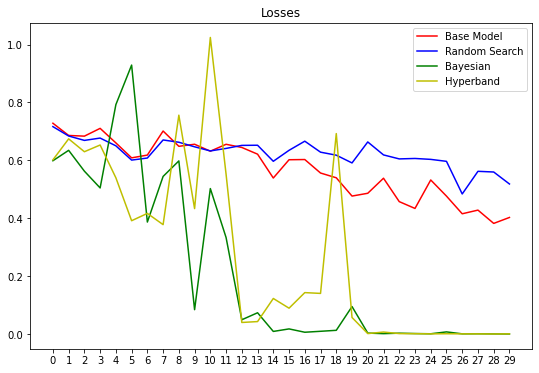

In [ ]:
from matplotlib import pyplot as plt

x = np.arange(len(base_losses))
width = 0.35

fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.plot(x, base_accuracies, '-r', label='Base Model')
ax1.plot(x, rand_accuracies, '-b', label='Random Search')
ax1.plot(x, bayesian_accuracies, '-g', label='Bayesian')
ax1.plot(x, hyperband_accuracies, '-y', label='Hyperband')

ax1.set_title('Accuracies')
ax1.set_xticks(x)
ax1.set_xticklabels(x)
ax1.legend()

fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.plot(x, base_losses, '-r', label='Base Model')
ax2.plot(x, rand_losses, '-b', label='Random Search')
ax2.plot(x, bayesian_losses, '-g', label='Bayesian')
ax2.plot(x, hyperband_losses, '-y', label='Hyperband')

ax2.set_title('Losses')
ax2.set_xticks(x)
ax2.set_xticklabels(x)
ax2.legend()

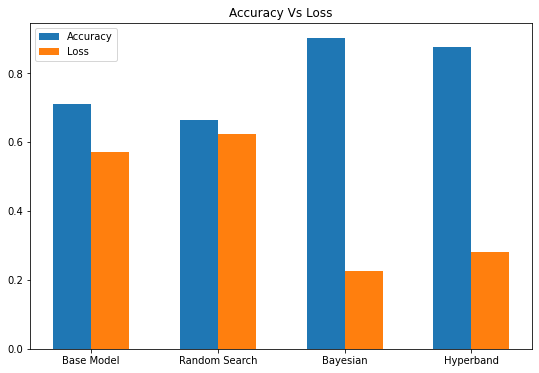

In [ ]:
labels = ['Base Model', 'Random Search', 'Bayesian', 'Hyperband']
accuracies = [np.mean(base_accuracies), np.mean(rand_accuracies), np.mean(bayesian_accuracies), np.mean(hyperband_accuracies)]
losses = [np.mean(base_losses), np.mean(rand_losses), np.mean(bayesian_losses), np.mean(hyperband_losses)]
x_tick_locations = np.arange(len(accuracies))
width = 0.3

fig3, ax3 = plt.subplots(figsize=(9,6))
rects1 = ax3.bar(x_tick_locations - width/2, accuracies, width, label='Accuracy')
rects2 = ax3.bar(x_tick_locations + width/2, losses, width, label='Loss')

ax3.set_title('Accuracy Vs Loss')
ax3.set_xticks(x_tick_locations)
ax3.set_xticklabels(labels)
ax3.legend()

#### The Bayesian model seems to give the best results among the four. Hence lets move on using this model for Valence prediction.


In [ ]:
valance_model = best_model_bayesian
valance_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 99, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 97, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               14156288  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               2

# Arousal Model

Lets go ahead and create CNN model to classify arousal as high(val > 5) or low(val < 5).

In [ ]:
def build_arousal_model():
  model = Sequential()
  
  model.add(Conv2D(100, (3,3), padding="valid", activation='relu', input_shape = (40, 101, 1)))
    
  model.add(Conv2D(100, (3, 3), activation='tanh' ))
    
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))
  
  model.add(Flatten())
   
  model.add(Dense(128, activation='tanh'))
  model.add(Dropout(0.50))
    
  model.add(Dense(2, activation='softplus'))
    
  sgd = SGD(lr = 0.001, momentum = 0.9, nesterov = True)
  model.compile(loss ='categorical_crossentropy', optimizer = sgd,metrics=['accuracy'])

  return model
    

In [ ]:
ar_base_losses, ar_base_accuracies = kfold_validate(X, y_arousal, build_arousal_model())

Epoch 1/10
24/24 [==============================] - 1s 30ms/step - loss: 0.7011 - accuracy: 0.5500 - val_loss: 0.6785 - val_accuracy: 0.6000
Epoch 2/10
24/24 [==============================] - 1s 23ms/step - loss: 0.6927 - accuracy: 0.5422 - val_loss: 0.6765 - val_accuracy: 0.6000
Epoch 3/10
24/24 [==============================] - 1s 22ms/step - loss: 0.6844 - accuracy: 0.5828 - val_loss: 0.6780 - val_accuracy: 0.6000
Epoch 4/10
24/24 [==============================] - 1s 23ms/step - loss: 0.6889 - accuracy: 0.5328 - val_loss: 0.6783 - val_accuracy: 0.6000
Epoch 5/10
24/24 [==============================] - 1s 23ms/step - loss: 0.6853 - accuracy: 0.5724 - val_loss: 0.6757 - val_accuracy: 0.6000
Epoch 6/10
24/24 [==============================] - 1s 23ms/step - loss: 0.6792 - accuracy: 0.5776 - val_loss: 0.6796 - val_accuracy: 0.6000
Epoch 7/10
24/24 [==============================] - 1s 25ms/step - loss: 0.6825 - accuracy: 0.5716 - val_loss: 0.6795 - val_accuracy: 0.6000
Epoch 8/10
24

In [ ]:
def build_hyperparameter_ar_model(hp):
    model = Sequential()
    
    model.add(Conv2D(hp.Int("input_units", min_value=32, max_value=512, step=16),
                     (3,3), padding="valid", activation=hp.Choice('input_activation', values = ['tanh', 'relu']), input_shape = (40, 101, 1)))
    
    for i in range(hp.Int("conv_layers",1, 8)):
        model.add(Conv2D(hp.Int(f"conv_{i}_units", min_value=32, max_value=512, step=32),
                         (3, 3), activation=hp.Choice(f'conv_{i}_activation', values = ['tanh', 'relu']) ))
    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(hp.Choice('dropout_1', values = [0.25,0.5,0.75])))
    
    model.add(Flatten())
    for i in range(hp.Int("dense_layers",0, 8)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=64, max_value=512, step=32), activation='tanh'))
    
    model.add(Dropout(hp.Choice('dropout_2', values = [0.25,0.5,0.75])))
    
    model.add(Dense(2, activation='softplus'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]) 
    
    sgd = SGD(lr = hp_learning_rate, momentum = 0.9, nesterov = True)
    model.compile(loss ='categorical_crossentropy', optimizer = sgd,metrics=['accuracy'])
    
    return model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_arousal)

X_train = X_train.reshape(X_train.shape[0], 40, 101, 1)
X_test = X_test.reshape(X_test.shape[0], 40, 101, 1)

LOG_DIR = f'{int(time.time())}'

In [ ]:
rand_tuner_arousal = RandomSearch(build_hyperparameter_model, 
                    objective='val_accuracy',
                    max_trials=5,
                    executions_per_trial = 1,
                    directory=LOG_DIR)

rand_tuner_arousal.search(x=X_train,
                          y=y_train,
                          epochs=10,
                          batch_size=50,
                          validation_data=(X_test, y_test))
rand_tuner_arousal.get_best_models(1)[0].save('randSearchArousalModel.h5')

Epoch 1/10
18/18 [==============================] - 1s 50ms/step - loss: 0.7343 - accuracy: 0.4956 - val_loss: 0.6827 - val_accuracy: 0.5867
Epoch 2/10
18/18 [==============================] - 1s 37ms/step - loss: 0.7295 - accuracy: 0.5289 - val_loss: 0.6821 - val_accuracy: 0.5833
Epoch 3/10
18/18 [==============================] - 1s 36ms/step - loss: 0.7302 - accuracy: 0.4967 - val_loss: 0.6817 - val_accuracy: 0.5833
Epoch 4/10
18/18 [==============================] - 1s 37ms/step - loss: 0.7342 - accuracy: 0.5067 - val_loss: 0.6813 - val_accuracy: 0.5867
Epoch 5/10
18/18 [==============================] - 1s 38ms/step - loss: 0.7266 - accuracy: 0.4889 - val_loss: 0.6806 - val_accuracy: 0.5833
Epoch 6/10
18/18 [==============================] - 1s 37ms/step - loss: 0.7173 - accuracy: 0.5144 - val_loss: 0.6802 - val_accuracy: 0.5800
Epoch 7/10
18/18 [==============================] - 1s 38ms/step - loss: 0.7437 - accuracy: 0.4878 - val_loss: 0.6800 - val_accuracy: 0.5767
Epoch 8/10
18

Epoch 1/10
18/18 [==============================] - 2s 107ms/step - loss: 0.9169 - accuracy: 0.5122 - val_loss: 0.6987 - val_accuracy: 0.5233
Epoch 2/10
18/18 [==============================] - 2s 100ms/step - loss: 0.9158 - accuracy: 0.4989 - val_loss: 0.6982 - val_accuracy: 0.5267
Epoch 3/10
18/18 [==============================] - 2s 99ms/step - loss: 0.9745 - accuracy: 0.4589 - val_loss: 0.6976 - val_accuracy: 0.5367
Epoch 4/10
18/18 [==============================] - 2s 97ms/step - loss: 0.9215 - accuracy: 0.5100 - val_loss: 0.6970 - val_accuracy: 0.5367
Epoch 5/10
18/18 [==============================] - 2s 101ms/step - loss: 0.9043 - accuracy: 0.5133 - val_loss: 0.6965 - val_accuracy: 0.5433
Epoch 6/10
18/18 [==============================] - 2s 96ms/step - loss: 0.8684 - accuracy: 0.5278 - val_loss: 0.6960 - val_accuracy: 0.5433
Epoch 7/10
18/18 [==============================] - 2s 97ms/step - loss: 0.8711 - accuracy: 0.5344 - val_loss: 0.6954 - val_accuracy: 0.5367
Epoch 8/10

Epoch 1/10
18/18 [==============================] - 2s 130ms/step - loss: 0.7311 - accuracy: 0.5000 - val_loss: 0.6914 - val_accuracy: 0.5033
Epoch 2/10
18/18 [==============================] - 2s 118ms/step - loss: 0.7393 - accuracy: 0.4944 - val_loss: 0.6913 - val_accuracy: 0.5067
Epoch 3/10
18/18 [==============================] - 2s 115ms/step - loss: 0.7349 - accuracy: 0.4900 - val_loss: 0.6913 - val_accuracy: 0.5033
Epoch 4/10
18/18 [==============================] - 2s 115ms/step - loss: 0.7294 - accuracy: 0.5056 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 5/10
18/18 [==============================] - 2s 115ms/step - loss: 0.7303 - accuracy: 0.5267 - val_loss: 0.6913 - val_accuracy: 0.5033
Epoch 6/10
18/18 [==============================] - 2s 114ms/step - loss: 0.7239 - accuracy: 0.5078 - val_loss: 0.6914 - val_accuracy: 0.5033
Epoch 7/10
18/18 [==============================] - 2s 114ms/step - loss: 0.7228 - accuracy: 0.5233 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 

KeyboardInterrupt: ignored

In [ ]:
bayesian_tuner = kt.BayesianOptimization(build_hyperparameter_model,
                                         objective='val_accuracy', 
                                         max_trials=5,
                                         executions_per_trial = 1,
                                         directory=LOG_DIR)

bayesian_tuner.search(x=X_train,
                      y=y_train,
                      epochs=10,
                      batch_size=50,
                      validation_data=(X_test, y_test))
bayesian_tuner.get_best_models(1)[0].save('bayesianModel.h5')

Epoch 1/10
20/20 [==============================] - 2s 94ms/step - loss: 0.7473 - accuracy: 0.4938 - val_loss: 0.6971 - val_accuracy: 0.4688
Epoch 2/10
20/20 [==============================] - 1s 71ms/step - loss: 0.7325 - accuracy: 0.5042 - val_loss: 0.6753 - val_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 1s 61ms/step - loss: 0.7160 - accuracy: 0.5302 - val_loss: 0.6745 - val_accuracy: 0.5938
Epoch 4/10
20/20 [==============================] - 1s 62ms/step - loss: 0.7222 - accuracy: 0.5083 - val_loss: 0.6804 - val_accuracy: 0.5906
Epoch 5/10
20/20 [==============================] - 1s 60ms/step - loss: 0.7247 - accuracy: 0.5115 - val_loss: 0.6786 - val_accuracy: 0.5906
Epoch 6/10
20/20 [==============================] - 1s 61ms/step - loss: 0.7041 - accuracy: 0.5333 - val_loss: 0.6826 - val_accuracy: 0.5938
Epoch 7/10
20/20 [==============================] - 1s 61ms/step - loss: 0.7120 - accuracy: 0.5312 - val_loss: 0.6812 - val_accuracy: 0.5938
Epoch 8/10
20

Epoch 1/10
20/20 [==============================] - 3s 149ms/step - loss: 0.7180 - accuracy: 0.4833 - val_loss: 0.6835 - val_accuracy: 0.5875
Epoch 2/10
20/20 [==============================] - 2s 107ms/step - loss: 0.6882 - accuracy: 0.5573 - val_loss: 0.6716 - val_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 2s 105ms/step - loss: 0.6784 - accuracy: 0.5719 - val_loss: 0.6881 - val_accuracy: 0.5250
Epoch 4/10
20/20 [==============================] - 2s 109ms/step - loss: 0.6827 - accuracy: 0.5573 - val_loss: 0.6712 - val_accuracy: 0.5969
Epoch 5/10
20/20 [==============================] - 2s 106ms/step - loss: 0.6749 - accuracy: 0.5760 - val_loss: 0.6724 - val_accuracy: 0.5906
Epoch 6/10
20/20 [==============================] - 2s 106ms/step - loss: 0.6594 - accuracy: 0.6229 - val_loss: 0.6668 - val_accuracy: 0.5938
Epoch 7/10
20/20 [==============================] - 2s 106ms/step - loss: 0.6561 - accuracy: 0.6167 - val_loss: 0.7143 - val_accuracy: 0.4719
Epoch 

Epoch 1/10
20/20 [==============================] - 11s 555ms/step - loss: 0.7202 - accuracy: 0.5115 - val_loss: 0.7056 - val_accuracy: 0.4219
Epoch 2/10
20/20 [==============================] - 9s 438ms/step - loss: 0.7368 - accuracy: 0.4958 - val_loss: 0.7054 - val_accuracy: 0.4156
Epoch 3/10
20/20 [==============================] - 9s 436ms/step - loss: 0.7404 - accuracy: 0.4896 - val_loss: 0.7053 - val_accuracy: 0.4156
Epoch 4/10
20/20 [==============================] - 9s 439ms/step - loss: 0.7377 - accuracy: 0.4979 - val_loss: 0.7051 - val_accuracy: 0.4219
Epoch 5/10
20/20 [==============================] - 9s 441ms/step - loss: 0.7278 - accuracy: 0.4854 - val_loss: 0.7050 - val_accuracy: 0.4219
Epoch 6/10
20/20 [==============================] - 9s 442ms/step - loss: 0.7311 - accuracy: 0.4958 - val_loss: 0.7049 - val_accuracy: 0.4219
Epoch 7/10
20/20 [==============================] - 9s 448ms/step - loss: 0.7247 - accuracy: 0.4948 - val_loss: 0.7048 - val_accuracy: 0.4250
Epoch

Epoch 1/10
20/20 [==============================] - 7s 350ms/step - loss: 0.8238 - accuracy: 0.4531 - val_loss: 0.7397 - val_accuracy: 0.4062
Epoch 2/10
20/20 [==============================] - 6s 282ms/step - loss: 0.7084 - accuracy: 0.4604 - val_loss: 0.7081 - val_accuracy: 0.4062
Epoch 3/10
20/20 [==============================] - 6s 285ms/step - loss: 0.6961 - accuracy: 0.4667 - val_loss: 0.6958 - val_accuracy: 0.4125
Epoch 4/10
20/20 [==============================] - 6s 286ms/step - loss: 0.6917 - accuracy: 0.5323 - val_loss: 0.6895 - val_accuracy: 0.5938
Epoch 5/10
20/20 [==============================] - 6s 286ms/step - loss: 0.6898 - accuracy: 0.5510 - val_loss: 0.6859 - val_accuracy: 0.5969
Epoch 6/10
20/20 [==============================] - 6s 283ms/step - loss: 0.6891 - accuracy: 0.5396 - val_loss: 0.6843 - val_accuracy: 0.5938
Epoch 7/10
20/20 [==============================] - 6s 282ms/step - loss: 0.6884 - accuracy: 0.5396 - val_loss: 0.6825 - val_accuracy: 0.5938
Epoch 

Epoch 1/10
20/20 [==============================] - 1s 25ms/step - loss: 0.7041 - accuracy: 0.5052 - val_loss: 0.6763 - val_accuracy: 0.5938
Epoch 2/10
20/20 [==============================] - 0s 12ms/step - loss: 0.6952 - accuracy: 0.5104 - val_loss: 0.6782 - val_accuracy: 0.5938
Epoch 3/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6889 - accuracy: 0.5365 - val_loss: 0.6752 - val_accuracy: 0.5938
Epoch 4/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6900 - accuracy: 0.5354 - val_loss: 0.7103 - val_accuracy: 0.4094
Epoch 5/10
20/20 [==============================] - 0s 14ms/step - loss: 0.6942 - accuracy: 0.5354 - val_loss: 0.6748 - val_accuracy: 0.6125
Epoch 6/10
20/20 [==============================] - 0s 12ms/step - loss: 0.6875 - accuracy: 0.5604 - val_loss: 0.6704 - val_accuracy: 0.5969
Epoch 7/10
20/20 [==============================] - 0s 11ms/step - loss: 0.6808 - accuracy: 0.5813 - val_loss: 0.6860 - val_accuracy: 0.5562
Epoch 8/10
20

INFO:tensorflow:Oracle triggered exit


In [ ]:
hyperband_tuner = kt.Hyperband(build_hyperparameter_model,
                               objective='val_accuracy', 
                               max_epochs=5, 
                               directory=LOG_DIR)

hyperband_tuner.search(x=X_train,
                      y=y_train,
                      epochs=10,
                      batch_size=50,
                      validation_data=(X_test, y_test))
hyperband_tuner.get_best_models(1)[0].save('hyperbandModel.h5')

Epoch 1/2
20/20 [==============================] - 2s 103ms/step - loss: 0.7891 - accuracy: 0.4771 - val_loss: 0.6954 - val_accuracy: 0.5312
Epoch 2/2
20/20 [==============================] - 1s 72ms/step - loss: 0.7751 - accuracy: 0.5010 - val_loss: 0.6952 - val_accuracy: 0.5281


Epoch 1/2
20/20 [==============================] - 8s 409ms/step - loss: 0.7587 - accuracy: 0.4781 - val_loss: 0.7766 - val_accuracy: 0.4094
Epoch 2/2
20/20 [==============================] - 7s 329ms/step - loss: 0.7613 - accuracy: 0.4771 - val_loss: 0.7765 - val_accuracy: 0.4094


Epoch 1/2
20/20 [==============================] - 8s 402ms/step - loss: 0.7294 - accuracy: 0.4750 - val_loss: 0.7216 - val_accuracy: 0.4250
Epoch 2/2
20/20 [==============================] - 6s 313ms/step - loss: 0.7320 - accuracy: 0.4677 - val_loss: 0.7188 - val_accuracy: 0.4156


Epoch 1/2
20/20 [==============================] - 7s 349ms/step - loss: 0.7825 - accuracy: 0.4833 - val_loss: 0.6939 - val_accuracy: 0.5656
Epoch 2/2
20/20 [==============================] - 5s 263ms/step - loss: 0.7421 - accuracy: 0.5063 - val_loss: 0.6937 - val_accuracy: 0.5656


Epoch 1/2
20/20 [==============================] - 23s 1s/step - loss: 0.7167 - accuracy: 0.5073 - val_loss: 0.6986 - val_accuracy: 0.4688
Epoch 2/2
20/20 [==============================] - 20s 976ms/step - loss: 0.7242 - accuracy: 0.4823 - val_loss: 0.6974 - val_accuracy: 0.4969


Epoch 3/5
20/20 [==============================] - 6s 283ms/step - loss: 0.7618 - accuracy: 0.5052 - val_loss: 0.6758 - val_accuracy: 0.5750
Epoch 4/5
20/20 [==============================] - 5s 268ms/step - loss: 0.7372 - accuracy: 0.5375 - val_loss: 0.6758 - val_accuracy: 0.5750
Epoch 5/5
20/20 [==============================] - 5s 267ms/step - loss: 0.7690 - accuracy: 0.4833 - val_loss: 0.6758 - val_accuracy: 0.5719


Epoch 3/5
20/20 [==============================] - 2s 80ms/step - loss: 0.8149 - accuracy: 0.5083 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 4/5
20/20 [==============================] - 1s 73ms/step - loss: 0.8068 - accuracy: 0.4896 - val_loss: 0.6882 - val_accuracy: 0.5500
Epoch 5/5
20/20 [==============================] - 1s 74ms/step - loss: 0.7940 - accuracy: 0.5156 - val_loss: 0.6882 - val_accuracy: 0.5500


Epoch 1/5
20/20 [==============================] - 11s 540ms/step - loss: 0.7682 - accuracy: 0.4948 - val_loss: 0.6773 - val_accuracy: 0.5750
Epoch 2/5
20/20 [==============================] - 9s 466ms/step - loss: 0.7542 - accuracy: 0.4896 - val_loss: 0.6774 - val_accuracy: 0.5781
Epoch 3/5
20/20 [==============================] - 7s 358ms/step - loss: 0.7534 - accuracy: 0.4875 - val_loss: 0.6776 - val_accuracy: 0.5750
Epoch 4/5
20/20 [==============================] - 7s 358ms/step - loss: 0.7421 - accuracy: 0.5125 - val_loss: 0.6777 - val_accuracy: 0.5719
Epoch 5/5
20/20 [==============================] - 7s 358ms/step - loss: 0.7446 - accuracy: 0.5104 - val_loss: 0.6776 - val_accuracy: 0.5719


Epoch 1/5
20/20 [==============================] - 8s 422ms/step - loss: 0.6993 - accuracy: 0.5021 - val_loss: 0.6864 - val_accuracy: 0.5938
Epoch 2/5
20/20 [==============================] - 6s 301ms/step - loss: 0.6977 - accuracy: 0.4990 - val_loss: 0.6864 - val_accuracy: 0.5938
Epoch 3/5
20/20 [==============================] - 6s 302ms/step - loss: 0.6907 - accuracy: 0.5323 - val_loss: 0.6864 - val_accuracy: 0.5938
Epoch 4/5
20/20 [==============================] - 6s 302ms/step - loss: 0.6945 - accuracy: 0.5042 - val_loss: 0.6864 - val_accuracy: 0.5938
Epoch 5/5
20/20 [==============================] - 6s 301ms/step - loss: 0.6955 - accuracy: 0.4938 - val_loss: 0.6864 - val_accuracy: 0.5938


Epoch 1/5
20/20 [==============================] - 4s 200ms/step - loss: 0.7507 - accuracy: 0.5260 - val_loss: 0.6909 - val_accuracy: 0.5938
Epoch 2/5
20/20 [==============================] - 3s 161ms/step - loss: 0.7237 - accuracy: 0.5500 - val_loss: 0.6859 - val_accuracy: 0.5938
Epoch 3/5
20/20 [==============================] - 3s 161ms/step - loss: 0.7326 - accuracy: 0.5219 - val_loss: 0.6829 - val_accuracy: 0.5938
Epoch 4/5
20/20 [==============================] - 3s 161ms/step - loss: 0.7167 - accuracy: 0.5260 - val_loss: 0.6812 - val_accuracy: 0.5938
Epoch 5/5
20/20 [==============================] - 3s 161ms/step - loss: 0.7166 - accuracy: 0.5083 - val_loss: 0.6810 - val_accuracy: 0.5875


INFO:tensorflow:Oracle triggered exit


In [ ]:
best_rand_tuner_arousal_model = load_model('randSearchArousalModel.h5')
ar_rand_losses, ar_rand_accuracies = kfold_validate(X, y_arousal, best_rand_tuner_arousal_model)

Epoch 1/10
24/24 [==============================] - 1s 54ms/step - loss: 0.6994 - accuracy: 0.5586 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 2/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6851 - accuracy: 0.5552 - val_loss: 0.6776 - val_accuracy: 0.6000
Epoch 3/10
24/24 [==============================] - 1s 34ms/step - loss: 0.6844 - accuracy: 0.5681 - val_loss: 0.6808 - val_accuracy: 0.6000
Epoch 4/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6889 - accuracy: 0.5526 - val_loss: 0.6728 - val_accuracy: 0.6000
Epoch 5/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6883 - accuracy: 0.5552 - val_loss: 0.6713 - val_accuracy: 0.6000
Epoch 6/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6858 - accuracy: 0.5716 - val_loss: 0.6726 - val_accuracy: 0.6000
Epoch 7/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6795 - accuracy: 0.5759 - val_loss: 0.6872 - val_accuracy: 0.6000
Epoch 8/10
24

In [ ]:
best_arousal_model_bayesian = load_model('bayesianArousalModel.h5')
ar_bayesian_losses, ar_bayesian_accuracies = kfold_validate(X, y_valance, best_model_bayesian)

Epoch 1/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0096 - accuracy: 0.9957 - val_loss: 7.4532e-04 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0087 - accuracy: 0.9966 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0166 - accuracy: 0.9948 - val_loss: 7.8179e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0094 - accuracy: 0.9974 - val_loss: 9.1147e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 9.8710e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 8.1497e-04 - val_accuracy: 

In [ ]:
best_arousal_model_hyperband = load_model('hyperbandArousalModel.h5')
ar_hyperband_losses, ar_hyperband_accuracies = kfold_validate(X, y_valance, best_model_hyperband)

Epoch 1/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0049 - accuracy: 0.9974 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0239 - accuracy: 0.9940 - val_loss: 8.9314e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 7.6283e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 0s 12ms/step - loss: 0.0104 - accuracy: 0.9974 - val_loss: 8.3573e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0092 - accuracy: 0.9974 - val_loss: 7.5491e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 0s 11ms/step - loss: 0.0107 - accuracy: 0.9957 - val_loss: 8.1532e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 0s 13ms/step - loss: 0.0068 - accuracy: 0.9974 - val_loss: 0.0012 - val_accuracy: 

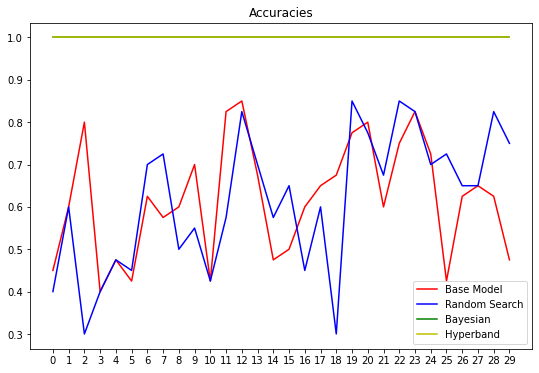

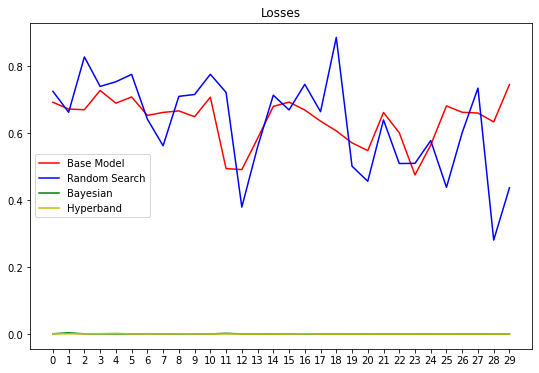

In [ ]:
x = np.arange(len(ar_base_accuracies))
width = 0.35

fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.plot(x, ar_base_accuracies, '-r', label='Base Model')
ax1.plot(x, ar_rand_accuracies, '-b', label='Random Search')
ax1.plot(x, ar_bayesian_accuracies, '-g', label='Bayesian')
ax1.plot(x, ar_hyperband_accuracies, '-y', label='Hyperband')

ax1.set_title('Accuracies')
ax1.set_xticks(x)
ax1.set_xticklabels(x)
ax1.legend()

fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.plot(x, ar_base_losses, '-r', label='Base Model')
ax2.plot(x, ar_rand_losses, '-b', label='Random Search')
ax2.plot(x, ar_bayesian_losses, '-g', label='Bayesian')
ax2.plot(x, ar_hyperband_losses, '-y', label='Hyperband')

ax2.set_title('Losses')
ax2.set_xticks(x)
ax2.set_xticklabels(x)
ax2.legend()


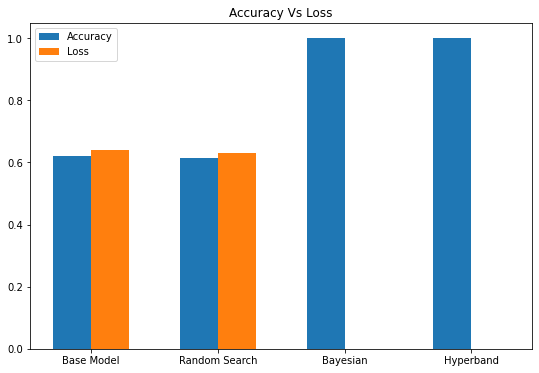

In [ ]:
labels = ['Base Model', 'Random Search', 'Bayesian', 'Hyperband']
accuracies = [np.mean(ar_base_accuracies), np.mean(ar_rand_accuracies), np.mean(ar_bayesian_accuracies), np.mean(ar_hyperband_accuracies)]
losses = [np.mean(ar_base_losses), np.mean(ar_rand_losses), np.mean(ar_bayesian_losses), np.mean(ar_hyperband_losses)]
x_tick_locations = np.arange(len(accuracies))
width = 0.3

fig3, ax3 = plt.subplots(figsize=(9,6))
rects1 = ax3.bar(x_tick_locations - width/2, accuracies, width, label='Accuracy')
rects2 = ax3.bar(x_tick_locations + width/2, losses, width, label='Loss')

ax3.set_title('Accuracy Vs Loss')
ax3.set_xticks(x_tick_locations)
ax3.set_xticklabels(labels)
ax3.legend()

The best model from bayesian optimization tuner seems to be the best performer.

In [ ]:
arousal_model = best_arousal_model_bayesian
arousal_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 99, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 97, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 27648)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1769536   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4

# Emotion classification

To classify emotion, we use this valance-arousal model<br>
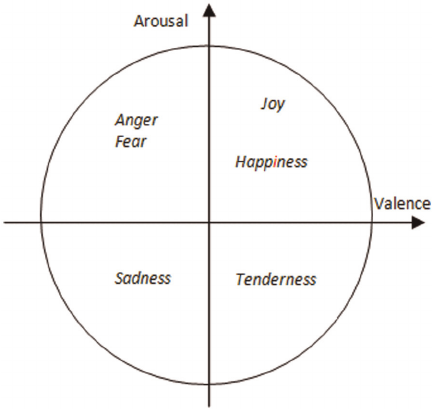

Source: https://www.researchgate.net/publication/270692594_Pulsed_Melodic_Affective_Processing_Musical_structures_for_increasing_transparency_in_emotional_computation

From the figure:

**Happiness**: High Valance/ High Arousal<br>
**Tenderness**: High Valance/ Low Arousal<br>
**Anger/Fear**: Low valance/ High Arousal<br>
**Sadness**: Low Valance/ Low Arousal



In [ ]:
def detect_emotion(valance, arousal):
  if (valance == 1 and arousal == 1):
    return 'Happiness'
  elif (valance == 1 and arousal == 0):
    return 'Tenderness'
  elif (valance == 0 and arousal == 1):
    return 'Anger/Fear'
  elif (valance == 0 and arousal == 0):
    return 'Sadness'

In [ ]:
test_set = test_set.reshape(test_set.shape[0], 40, 101, 1)
y_valance_predicted = valance_model.predict(test_set)
y_arousal_predicted = arousal_model.predict(test_set)

In [1]:
for val, ar in zip(y_valance_predicted, y_arousal_predicted):
  print(detect_emotion(val, ar))

NameError: ignored